# Direct spectrum estimation of speech signal

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.Node
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file = "../data/woman.wav"      # specify sound location
fs_desired = 8000                        # specify desired sampling frequency

# inference and modelling
AR_order = 10                            # order of auto-regressive model
iterations = 3                           # number of iterations for variational message passing
Œõ_meas = 1e-3                            # assumed precision of measurement noise
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[2*fs_time+1:5*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQAwqTe7XRCwO9Q2bzwppuc7oYC+uwo4yrtuw8e7TCLgPGMV8ryo+3y7u/Lpu6yiLjohO7s8KjrIvPzJFbqVj4y8oznoPHgJ4jz+AkG80OlkvUWKg7st2kY9WsS6vCPsTLyCGCG8u5hwO9AYXD2zjSW9NrUwvP7STrxU+xo94DEJvFRzE704KAQ9votUvfSVuDy5xw+7C0ORvAXmd7xLok66sx5uPQNfX7wu7HO9tTsAPCVIeD1Pz8S82r6LvTXyMTznyAo9jFuZO0TlMb365we9/3kdPSDFLzz67cO8oUeFvO/2ZryIrDM949KnvNyvLr0OGY68cF1aPVcEwbvANJK9RsTaOwn8CD1LT8w7rjNcvTDSvDwPsHW8VNMovEP0U7zydGi8Z12/vBx2LLxtbds8pneyumCblLyg+Y+8dh4DPQ/j/jpgCps8XyZ4vcmqOjzqSX08+F2OvEXOQbvv2S66RfzcuxX7B7z6iKA7RzO/vNXtnTvGWZE8sxbPu7bsQzuJhVq9QJFrvKKZKD2xrAK9XQnIu0sXf7zw/U48qjnNujcvfrtQkA26G3jLu6wQszyKN2u8CSBTPOLe97hN/0E7SzkivemYDL0gj848oNATPD1g07yYi8E7aDyhvJtYHT07dVq8FzjcvAHxEz24uXe8gh0BPXILcr0kZBU9e5giPKHYM724rmu89EJZu3byNz1jbiq9OQqnu3AmN7zG7988/L5zPFoZPb0gmq070guSOw3+hDxZcLK8XvUKvDP+kbwtwUc9l+HpvEkmsrzIDKa8IbfNPEZKmTvNtQ+94NX3vEtsgDwdFEE9FGTkvCkDT7wim6e8Wg4wPAjVtzyGw3W8rky7vGYQ7DxjE9G8OEWtO2TLSDo2Z9O7iv2MPASPjjuLGa28eAKgPE2fczva4BY6rSUTvXsQpDxGA/Q8ddzaOjGdubzQ2tI7h80mvGURF7x4Sgs9MUBMuyZgrbxstQK8E5eJOwbRjrt6hMu73AZLO20qCT0h78W8lO9HvNXQsLsjHRo9vuEpvHdLLLxSuJy59LgaPBJVqry8msC8DLW7PEjIoDwLnpC80flSPP4plzt6L4u4NcQ2PCJ3OL2RUeY8K/QKvHHVRjwX0yk8LH+JOkSQDj1Waii8Uo/6uZTckDu0sP67PtEavO6sHzxy+rI8VYiEvNeZazzC0Le65RLHvAjwiTym61w8aT9VPMJIxbp2GHg71jyzO3V3JLzRs0I8klclvKPZ9Tu2lws9b8hTvItKDL2ahgs8YgaBux8MhruHSJ87hXL/vEeZpDwpueE8Z1cgvUDg5jsy2648dg0qvDTDNbzgF6E7DYfhPHIyHb1cgvy7ciu9vOhBPTxyDkk7CepxvN92izzGoCe4x7Jzu6HC+rxEUQ08V1d6PD7XtbzZP/m8XK1LO7E0VD1wpcG8gV8XvF3Z8rscszY8Qs1YvBk1JLx1uyQ8Q29eOqXuprzdnQS84a6iPBdJTbt5Pga8E1lhvFkQnjxBbkY8S30yvcg/JT0a6xi9lGkwvFc/HDxVo6w8GswavJIm7Tvlezu8b6e7PMv8KryaNlO9hiDYO6ZxwzwztHY8R/9cvTnP3DyxEys6/WIrPTydKr2riZe8X6+LPEH0Cz1AzJ+8LatZvXcLMzwr65U8pbzAPEjrCr3b+7q84frbOgkArTxo8xM8H+jlvAYNFbuREaU77RbuPEmRw7zLosG7406kPBDaszzu52q8I2AOvT/GM7yY5ue8qRsfPfqEtLyMB/G7gPuKPNxYvLuwIIm7syKzvNoV+7sKAB49C2fhupQhqruVEng8fu+wvIgLwTw6X368ingWOw/anrmT46I8QysAvbIKjrw8boQ8sxnVPL0gbDvBuA+9YUBbOnwqLj2ScuS8cif/OiYvRLs5hko85BevPMHAKjwUotq8G8RzvDDt2TxrLQ89CLBZvJPHvjvlolA7fI+QvOT9jzsEuiA8mraXu/m2LbxZpSI9X8WyPGRY87xHiS47acWFu3ZslTw3pRk7PD/+u0wvYztulJE849b3PFIKdb0gkgG8RbJmPb781brDPgu9OUy2O1xA4DtYybk86Cn2Ox/Pmrw8uri7UdlBPRSUWTwAob+8PB2Eu5fcPjxDb9M8TxtWO9JpBb260KS8iI2KPUSb8DtQv4u9ty9ZPDtbzDypSNM8pt+WPLvsBL0wvYY7eaEIPbq4I7tuBTG9YjaRvDgzlj0/K7q7go8hvQejLzxZRPI8GfOUOynQqjtos9e7frryunCN8jrRcQs8CVG9vC3iyjsQQcQ8+gLku/CjW7uln2O7fgqhPAgWkbyLL+w77YuBOvpPV7xEhnU8KCwIPA/C6rt9pfU7ki9yOzgim7wRHZU8cOELPMBZWTw185680lLLPEbAoDu5puu8/U69POSfejyu+cy88Y8fvIWvwTyC5IM8812PvJAiALwDxgs9DZ7xO71rqjpMD6q8pwOAvID58DwXQ4c65ctYPIXJOr0uho48+4v3u7MfGTz0Vo68TZtGPIDzlbzt8hY7RDehPC3EyjxhmdS8E3SmvDqpJbvJ4KY8G57UO2zWSLwhokG85EmBPCIkkDxSXwM7HMzLPCjSBrxO6DS9ZqUHPL39kDsJuhO8j2rqu65mWzyAHQc9W5egvLvJwTzuc907+X6ivFDpdzwpvoi8AprOvM4NCD17I4c7fbJhu7l4lrt9JxU9HwkGvXt7lLyyuI08uXQYPSd/pTueUJe86siPO+MlrDxdRAK9f1wDO7N3cDtK8H08E88HvUP6Y7vDMg49u4Y9vDiJjLxRe6e8e0RrPWNwIjywAAa9zR7ivHlWBz0HBos8aTcvvOcumbxTzok8j5OgPKZtPTxVmP28mkuUvPklIjviLzW5N2IkPN0Q+zzAX6u8C6LWPIUUrLpq2Ca9/3HJPFlZI73lfmc8VPtyPIfIVTz/JIw8DGnwvAn24Lt7lG488Gf/uwfvNjv79AQ822QEvL/yY70IQgO8gMfUPGlgsjwj8Za91sVhPfkG7jwiaUe8OwixvIAR7ToOlg09g2gavUQ7sbrqJMM7l8z+O6Y3Ujxhtha9tDFlO0Ti+zzROuO7GFmDvA0BdDzufto5R18ovMZaOTpnwGw8MkkXvZAK2zsLo5Y7Z/nouprZ8zxfccy7ZXZQvBgQ9byw9688UPqSu6irNL07dZY8MWxdusuT1buqLB28aGYBPaz/Z7xBkIO81BcuPNVTALx9XkM9JW09vYuUsbyRm6K6UBW4POPEF72g9Bq8c70EPc5YlruK3Je8JRq1OhSsq7xxyhS8K1FIuoA2+rqgQ3O7jTFevNcgrjw4eC28EASnO36f17p9VPG8oxCcPL/pYTwGvy29J1r2O+LvhLx5kvI8aKEEvf4gxLu7YMk7uixbvLzH0Dz6S0M8qSwhvQvEHTzkvF478EMlPHITjTw5MBC98xVLO3tmxbsuaqq7M4grPPhhMj2rvUi9bN+SvNaUnjw24846/FxlvCh2KDyBJrS8YuNePMq9Oz2nDyi9kOAHvOPcq7ub0O48u2gBvXUIMzuHiDs8ZaLguzfaGb3Dikk9p4mRvIF46Lya+Wc7C4qgvH3IrDxAx6274LXRvPv7AT0Vd5m8DCi2vIo5HbzMzbs7Z3YovTo/pTpkZ228+g0wPHGAAjy4XRg8vWh0vGfAL72mvxg8t64hPGACIrwA2/M7VOGFPBTDJ7tkNoC70cqFvFXFmbyLlJ46xXr3vL6bGj1CkFy8VofNvJxZlLvqpqs8dqfEu5oWPr0D74I8HxyuPDBTibcmhi28DDhNPOxG3LxAiGs8mGURvKzlIr0YhMA7ZLwwu91SLj1juAy9TXvhvBZU+DwtxLE8wwj2vLlsNDxzM

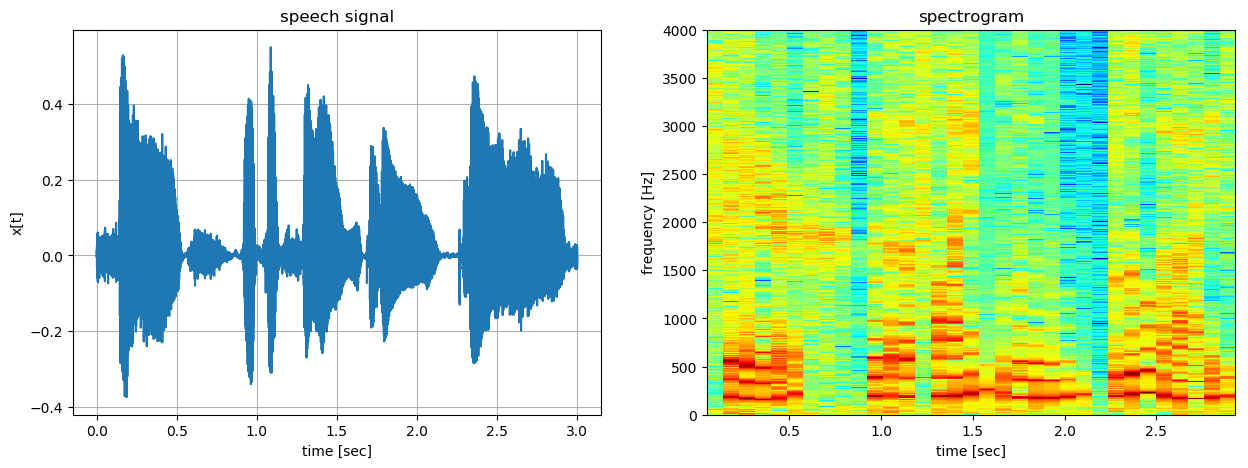

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Generative model

In [5]:
# create factor graphs
fg = FactorGraph()

# Gaussian mixture
@RV p ~ ForneyLab.Beta(placeholder(:a_p),placeholder(:b_p))
@RV z ~ ForneyLab.Bernoulli(p)
@RV Œ∏_AR ~ GaussianMeanPrecision(placeholder(:Œº_Œ∏, dims=(AR_order,)), placeholder(:Œõ_Œ∏, dims=(AR_order, AR_order)))
@RV W_AR ~ Wishart(tiny*Ic(AR_order), AR_order)
@RV Œ∏_0 ~ GaussianMeanPrecision(zeros(AR_order), huge*Ic(AR_order))
@RV W_0 ~ Wishart(tiny*Ic(AR_order),AR_order)
@RV Œ∏ ~ GaussianMixture(z, Œ∏_AR, W_AR, Œ∏_0, W_0)


# AR node
@RV Œ≥ ~ ForneyLab.Gamma(placeholder(:a_Œ≥), placeholder(:b_Œ≥))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:Œº_Sprev, dims=(AR_order,)), placeholder(:Œõ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.Autoregressive(Œ∏, Sprev, Œ≥)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x ~ DotProduct(d, S)
@RV y ~ GaussianMeanPrecision(x, Œõ_meas)
placeholder(y, :y)

ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 655266509284177428 -->
 655266509284177428 
 
 W 
 wishart_2 
 
<!-- 6693874815286592056 -->
 6693874815286592056 
 
 clamp_5 
 
<!-- 655266509284177428--6693874815286592056 -->
 655266509284177428--6693874815286592056 
 
 clamp_5 
 1 out 
 2 v 
 
<!-- 11333723144740362569 -->
 11333723144740362569 
 
 clamp_6 
 
<!-- 655266509284177428--11333723144740362569 -->
 655266509284177428--11333723144740362569 
 
 clamp_6 
 1 out 
 3 nu 
 
<!-- 8498314892803316057 -->
 8498314892803316057 
 
 placeholder_a_Œ≥ 
 
<!-- 7814353123647570976 -->
 7814353123647570976 
 
 dot 
 dotproduct_1 
 
<!-- 5197367639355347163 -->
 5197367639355347163 
 
 AR 
 autoregressive_1 
 
<!-- 7814353123647570976--5197367639355347163 -->
 7814353123647570976--5197367639355347163 
 
 S 
 1 y 
 3 in2 
 
<!-- 14189887397210187719 -->
 14189887397210187719 
 
 clamp_7 
 
<!-- 7814353123647570976--14189887397210187719 -->
 7814353123647570976--14189887397210187719 
 
 clamp_7 
 1 out 
 2 in1 
 
<!-- 8257530090427057280 -->
 8257530090427057280 
 
 placeholder_Œõ_Œ∏ 
 
<!-- 17416622725267428853 -->
 17416622725267428853 
 
 ùí© 
 gaussianmeanprecision_1 
 
<!-- 17416622725267428853--8257530090427057280 -->
 17416622725267428853--8257530090427057280 
 
 Œõ_Œ∏ 
 1 out 
 3 w 
 
<!-- 1197538809016242009 -->
 1197538809016242009 
 
 placeholder_Œº_Œ∏ 
 
<!-- 17416622725267428853--1197538809016242009 -->
 17416622725267428853--1197538809016242009 
 
 Œº_Œ∏ 
 1 out 
 2 m 
 
<!-- 13558019786154018630 -->
 13558019786154018630 
 
 Gam 
 gamma_1 
 
<!-- 5197367639355347163--13558019786154018630 -->
 5197367639355347163--13558019786154018630 
 
 Œ≥ 
 1 out 
 4 Œ≥ 
 
<!-- 12736170067054683748 -->
 12736170067054683748 
 
 GM 
 gaussianmixture_1 
 
<!-- 5197367639355347163--12736170067054683748 -->
 5197367639355347163--12736170067054683748 
 
 Œ∏ 
 1 out 
 3 Œ∏ 
 
<!-- 16293332236018381006 -->
 16293332236018381006 
 
 ùí© 
 gaussianmeanprecision_3 
 
<!-- 5197367639355347163--16293332236018381006 -->
 5197367639355347163--16293332236018381006 
 
 Sprev 
 1 out 
 2 x 
 
<!-- 16048944948377174779 -->
 16048944948377174779 
 
 clamp_4 
 
<!-- 13558019786154018630--8498314892803316057 -->
 13558019786154018630--8498314892803316057 
 
 a_Œ≥ 
 1 out 
 2 a 
 
<!-- 12036614731497812970 -->
 12036614731497812970 
 
 placeholder_b_Œ≥ 
 
<!-- 13558019786154018630--12036614731497812970 -->
 13558019786154018630--12036614731497812970 
 
 b_Œ≥ 
 1 out 
 3 b 
 
<!-- 2418093250279442360 -->
 2418093250279442360 
 
 Beta 
 beta_1 
 
<!-- 14122346820272577343 -->
 14122346820272577343 
 
 placeholder_a_p 
 
<!-- 2418093250279442360--14122346820272577343 -->
 2418093250279442360--14122346820272577343 
 
 a_p 
 1 out 
 2 a 
 
<!-- 17286875613705662762 -->
 17286875613705662762 
 
 placeholder_b_p 
 
<!-- 2418093250279442360--17286875613705662762 -->
 2418093250279442360--17286875613705662762 
 
 b_p 
 1 out 
 3 b 
 
<!-- 15704276227870435683 -->
 15704276227870435683 
 
 ùí© 
 gaussianmeanprecision_2 
 
<!-- 15704276227870435683--16048944948377174779 -->
 15704276227870435683--16048944948377174779 
 
 clamp_4 
 1 out 
 3 w 
 
<!-- 1785410598132892535 -->
 1785410598132892535 
 
 clamp_3 
 
<!-- 15704276227870435683--1785410598132892535 -->
 15704276227870435683--1785410598132892535 
 
 clamp_3 
 1 out 
 2 m 
 
<!-- 18341213164686469655 -->
 18341213164686469655 
 
 placeholder_Œº_Sprev 
 
<!-- 5092384134040090475 -->
 5092384134040090475 
 
 Ber 
 bernoulli_1 
 
<!-- 5092384134040090475--241809325027944236

## Algorithm generation

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(Œ∏, [S, Sprev], Œ≥, z, p, Œ∏_AR, ids=[:Œ∏ :S :Œ≥ :z :p :Œ∏_AR])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))
println(algo)
;

begin

function stepŒ≥!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_Œ≥]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_Œ≥]))
messages[2] = ruleSVariationalARIn3PPPN(marginals[:S_Sprev], marginals[:Œ∏], nothing)

marginals[:Œ≥] = messages[1].dist * messages[2].dist

return marginals

end

function stepp!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBBetaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_p]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_p]))
messages[2] = ruleVBBernoulliIn1(marginals[:z], nothing)

marginals[:p] = messages[1].dist * messages[2].dist

return marginals

end

function stepS!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 6))

messages[1] = 

## Perform inference

In [15]:
# create memory variables
Œº_Œ∏_mem = Array{Array{Float64, 1}}(undef, length(x_time))
Œõ_Œ∏_mem = Array{Array{Float64, 2}}(undef, length(x_time))
a_Œ≥_mem = Array{Float64}(undef, length(x_time))
b_Œ≥_mem = Array{Float64}(undef, length(x_time))
z_mem = Array{Float64}(undef, length(x_time))
Œº_x_pred = Array{Float64}(undef, length(x_time))
var_x_pred = Array{Float64}(undef, length(x_time))

# set priors
Œº_Œ∏_min = randn(AR_order)
Œõ_Œ∏_min = 1e0 * Ic(AR_order)
Œº_S_min = zeros(AR_order)
Œõ_S_min = 1e0 * Ic(AR_order)
a_Œ≥_min = 0.001
b_Œ≥_min = 0.001
a_p_min = 1
b_p_min = 1

# create progress bar
p = Progress(length(x_time), 1, "Observed ")

# create marginals dictionary
marginals = Dict(:Œ∏_AR => vague(GaussianMeanPrecision, AR_order),
                 :Œ∏_0 => ProbabilityDistribution(ForneyLab.Multivariate, ForneyLab.GaussianMeanPrecision, m=zeros(AR_order), w=1e4*Ic(AR_order)),
                 :W_AR => ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=tiny*Ic(AR_order), nu=AR_order),
                 :W_0 => ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=tiny*Ic(AR_order), nu=AR_order),
                 :Œ∏ => vague(GaussianMeanPrecision, AR_order),
                 :Œ≥ => vague(ForneyLab.Gamma),
                 :Sprev => vague(GaussianMeanPrecision, AR_order),
                 :z => vague(ForneyLab.Bernoulli),
                 :p => vague(ForneyLab.Beta))

# create messages array 
messages= Array{Message}(undef, 6)

# loop through samples
for k = 1:length(x_time)
    
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data = Dict(:y => x_time[k],
                :Œº_Œ∏ => Œº_Œ∏_min,
                :Œõ_Œ∏ => Œõ_Œ∏_min,
                :a_Œ≥ => a_Œ≥_min,
                :b_Œ≥ => b_Œ≥_min,
                :Œº_Sprev => Œº_S_min,
                :Œõ_Sprev => Œõ_S_min,
                :b_p => b_p_min, 
                :a_p => a_p_min)
    
    # get prediction
    stepS!(data, marginals, messages)
    Œº_x_pred[k] = ForneyLab.unsafeMean(messages[3].dist)
    var_x_pred[k] = ForneyLab.unsafeVar(messages[3].dist)
    
    # perform variational message passing iterations
    for it = 1:iterations
        stepS!(data, marginals)
        stepŒ∏!(data, marginals)
        stepŒ∏_AR!(data, marginals)
        stepŒ≥!(data, marginals)
        stepz!(data, marginals)
        stepp!(data, marginals)
    end
    
    # update priors
    Œº_Œ∏_min = ForneyLab.unsafeMean(marginals[:Œ∏_AR])
    Œõ_Œ∏_min = ForneyLab.unsafePrecision(marginals[:Œ∏_AR])
    Œº_S_min = ForneyLab.unsafeMean(marginals[:S])
    Œõ_S_min = ForneyLab.unsafePrecision(marginals[:S])
    a_Œ≥_min = marginals[:Œ≥].params[:a]
    b_Œ≥_min = marginals[:Œ≥].params[:b]
    a_p_min = marginals[:p].params[:a]
    b_p_min = marginals[:p].params[:b]
    
    # save infered parameters
    Œº_Œ∏_mem[k] = Œº_Œ∏_min
    Œõ_Œ∏_mem[k] = Œõ_Œ∏_min
    a_Œ≥_mem[k] = a_Œ≥_min
    b_Œ≥_mem[k] = b_Œ≥_min
    z_mem[k] = marginals[:z].params[:p]
    
end

Observed 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:01:17


In [16]:
plt.plot(z_mem)

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000251BC18>

In [17]:
marginals

Dict{Symbol,ProbabilityDistribution} with 12 entries:
  :W_AR    => W(v=[[1.00e-12, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0‚Ä¶
  :p       => Beta(a=1.20e+04, b=1.20e+04)‚Ä¶
  :Œ∏_0     => ùí©(m=[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],‚Ä¶
  :S       => ùí©(xi=[-3.73e-06, 2.30e-05, -3.39e-05, 9.24e-06, -2.49e-07, 1.19e-‚Ä¶
  :x       => ùí©(xi=-3.73e-06, w=1.00e-03)‚Ä¶
  :Œ∏_AR    => ùí©(xi=[0.19, -1.34, -0.43, 0.05, -1.84, -2.38, 1.63, -1.48, 1.54, ‚Ä¶
  :W_0     => W(v=[[1.00e-12, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0‚Ä¶
  :Sprev   => ùí©(xi=[2.30e-05, -3.39e-05, 9.24e-06, -2.49e-07, 1.19e-05, 3.59e-0‚Ä¶
  :z       => Ber(p=0.50)‚Ä¶
  :Œ∏       => ùí©(xi=[9.67e-13, -6.72e-12, -2.13e-12, 2.71e-13, -9.21e-12, -1.19e‚Ä¶
  :S_Sprev => ùí©(m=[-3.73e-03, 3.83e-06, -7.00e-08, 2.03e-09, -1.58e-11, 3.54e-1‚Ä¶
  :Œ≥       => Gam(a=1.20e+04, b=3.12e+10)‚Ä¶

## Predictions

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQAwqTe7XRCwO9Q2bzwppuc7oYC+uwo4yrtuw8e7TCLgPGMV8ryo+3y7u/Lpu6yiLjohO7s8KjrIvPzJFbqVj4y8oznoPHgJ4jz+AkG80OlkvUWKg7st2kY9WsS6vCPsTLyCGCG8u5hwO9AYXD2zjSW9NrUwvP7STrxU+xo94DEJvFRzE704KAQ9votUvfSVuDy5xw+7C0ORvAXmd7xLok66sx5uPQNfX7wu7HO9tTsAPCVIeD1Pz8S82r6LvTXyMTznyAo9jFuZO0TlMb365we9/3kdPSDFLzz67cO8oUeFvO/2ZryIrDM949KnvNyvLr0OGY68cF1aPVcEwbvANJK9RsTaOwn8CD1LT8w7rjNcvTDSvDwPsHW8VNMovEP0U7zydGi8Z12/vBx2LLxtbds8pneyumCblLyg+Y+8dh4DPQ/j/jpgCps8XyZ4vcmqOjzqSX08+F2OvEXOQbvv2S66RfzcuxX7B7z6iKA7RzO/vNXtnTvGWZE8sxbPu7bsQzuJhVq9QJFrvKKZKD2xrAK9XQnIu0sXf7zw/U48qjnNujcvfrtQkA26G3jLu6wQszyKN2u8CSBTPOLe97hN/0E7SzkivemYDL0gj848oNATPD1g07yYi8E7aDyhvJtYHT07dVq8FzjcvAHxEz24uXe8gh0BPXILcr0kZBU9e5giPKHYM724rmu89EJZu3byNz1jbiq9OQqnu3AmN7zG7988/L5zPFoZPb0gmq070guSOw3+hDxZcLK8XvUKvDP+kbwtwUc9l+HpvEkmsrzIDKa8IbfNPEZKmTvNtQ+94NX3vEtsgDwdFEE9FGTkvCkDT7wim6e8Wg4wPAjVtzyGw3W8rky7vGYQ7DxjE9G8OEWtO2TLSDo2Z9O7iv2MPASPjjuLGa28eAKgPE2fczva4BY6rSUTvXsQpDxGA/Q8ddzaOjGdubzQ2tI7h80mvGURF7x4Sgs9MUBMuyZgrbxstQK8E5eJOwbRjrt6hMu73AZLO20qCT0h78W8lO9HvNXQsLsjHRo9vuEpvHdLLLxSuJy59LgaPBJVqry8msC8DLW7PEjIoDwLnpC80flSPP4plzt6L4u4NcQ2PCJ3OL2RUeY8K/QKvHHVRjwX0yk8LH+JOkSQDj1Waii8Uo/6uZTckDu0sP67PtEavO6sHzxy+rI8VYiEvNeZazzC0Le65RLHvAjwiTym61w8aT9VPMJIxbp2GHg71jyzO3V3JLzRs0I8klclvKPZ9Tu2lws9b8hTvItKDL2ahgs8YgaBux8MhruHSJ87hXL/vEeZpDwpueE8Z1cgvUDg5jsy2648dg0qvDTDNbzgF6E7DYfhPHIyHb1cgvy7ciu9vOhBPTxyDkk7CepxvN92izzGoCe4x7Jzu6HC+rxEUQ08V1d6PD7XtbzZP/m8XK1LO7E0VD1wpcG8gV8XvF3Z8rscszY8Qs1YvBk1JLx1uyQ8Q29eOqXuprzdnQS84a6iPBdJTbt5Pga8E1lhvFkQnjxBbkY8S30yvcg/JT0a6xi9lGkwvFc/HDxVo6w8GswavJIm7Tvlezu8b6e7PMv8KryaNlO9hiDYO6ZxwzwztHY8R/9cvTnP3DyxEys6/WIrPTydKr2riZe8X6+LPEH0Cz1AzJ+8LatZvXcLMzwr65U8pbzAPEjrCr3b+7q84frbOgkArTxo8xM8H+jlvAYNFbuREaU77RbuPEmRw7zLosG7406kPBDaszzu52q8I2AOvT/GM7yY5ue8qRsfPfqEtLyMB/G7gPuKPNxYvLuwIIm7syKzvNoV+7sKAB49C2fhupQhqruVEng8fu+wvIgLwTw6X368ingWOw/anrmT46I8QysAvbIKjrw8boQ8sxnVPL0gbDvBuA+9YUBbOnwqLj2ScuS8cif/OiYvRLs5hko85BevPMHAKjwUotq8G8RzvDDt2TxrLQ89CLBZvJPHvjvlolA7fI+QvOT9jzsEuiA8mraXu/m2LbxZpSI9X8WyPGRY87xHiS47acWFu3ZslTw3pRk7PD/+u0wvYztulJE849b3PFIKdb0gkgG8RbJmPb781brDPgu9OUy2O1xA4DtYybk86Cn2Ox/Pmrw8uri7UdlBPRSUWTwAob+8PB2Eu5fcPjxDb9M8TxtWO9JpBb260KS8iI2KPUSb8DtQv4u9ty9ZPDtbzDypSNM8pt+WPLvsBL0wvYY7eaEIPbq4I7tuBTG9YjaRvDgzlj0/K7q7go8hvQejLzxZRPI8GfOUOynQqjtos9e7frryunCN8jrRcQs8CVG9vC3iyjsQQcQ8+gLku/CjW7uln2O7fgqhPAgWkbyLL+w77YuBOvpPV7xEhnU8KCwIPA/C6rt9pfU7ki9yOzgim7wRHZU8cOELPMBZWTw185680lLLPEbAoDu5puu8/U69POSfejyu+cy88Y8fvIWvwTyC5IM8812PvJAiALwDxgs9DZ7xO71rqjpMD6q8pwOAvID58DwXQ4c65ctYPIXJOr0uho48+4v3u7MfGTz0Vo68TZtGPIDzlbzt8hY7RDehPC3EyjxhmdS8E3SmvDqpJbvJ4KY8G57UO2zWSLwhokG85EmBPCIkkDxSXwM7HMzLPCjSBrxO6DS9ZqUHPL39kDsJuhO8j2rqu65mWzyAHQc9W5egvLvJwTzuc907+X6ivFDpdzwpvoi8AprOvM4NCD17I4c7fbJhu7l4lrt9JxU9HwkGvXt7lLyyuI08uXQYPSd/pTueUJe86siPO+MlrDxdRAK9f1wDO7N3cDtK8H08E88HvUP6Y7vDMg49u4Y9vDiJjLxRe6e8e0RrPWNwIjywAAa9zR7ivHlWBz0HBos8aTcvvOcumbxTzok8j5OgPKZtPTxVmP28mkuUvPklIjviLzW5N2IkPN0Q+zzAX6u8C6LWPIUUrLpq2Ca9/3HJPFlZI73lfmc8VPtyPIfIVTz/JIw8DGnwvAn24Lt7lG488Gf/uwfvNjv79AQ822QEvL/yY70IQgO8gMfUPGlgsjwj8Za91sVhPfkG7jwiaUe8OwixvIAR7ToOlg09g2gavUQ7sbrqJMM7l8z+O6Y3Ujxhtha9tDFlO0Ti+zzROuO7GFmDvA0BdDzufto5R18ovMZaOTpnwGw8MkkXvZAK2zsLo5Y7Z/nouprZ8zxfccy7ZXZQvBgQ9byw9688UPqSu6irNL07dZY8MWxdusuT1buqLB28aGYBPaz/Z7xBkIO81BcuPNVTALx9XkM9JW09vYuUsbyRm6K6UBW4POPEF72g9Bq8c70EPc5YlruK3Je8JRq1OhSsq7xxyhS8K1FIuoA2+rqgQ3O7jTFevNcgrjw4eC28EASnO36f17p9VPG8oxCcPL/pYTwGvy29J1r2O+LvhLx5kvI8aKEEvf4gxLu7YMk7uixbvLzH0Dz6S0M8qSwhvQvEHTzkvF478EMlPHITjTw5MBC98xVLO3tmxbsuaqq7M4grPPhhMj2rvUi9bN+SvNaUnjw24846/FxlvCh2KDyBJrS8YuNePMq9Oz2nDyi9kOAHvOPcq7ub0O48u2gBvXUIMzuHiDs8ZaLguzfaGb3Dikk9p4mRvIF46Lya+Wc7C4qgvH3IrDxAx6274LXRvPv7AT0Vd5m8DCi2vIo5HbzMzbs7Z3YovTo/pTpkZ228+g0wPHGAAjy4XRg8vWh0vGfAL72mvxg8t64hPGACIrwA2/M7VOGFPBTDJ7tkNoC70cqFvFXFmbyLlJ46xXr3vL6bGj1CkFy8VofNvJxZlLvqpqs8dqfEu5oWPr0D74I8HxyuPDBTibcmhi28DDhNPOxG3LxAiGs8mGURvKzlIr0YhMA7ZLwwu91SLj1juAy9TXvhvBZU+DwtxLE8wwj2vLlsNDxzM

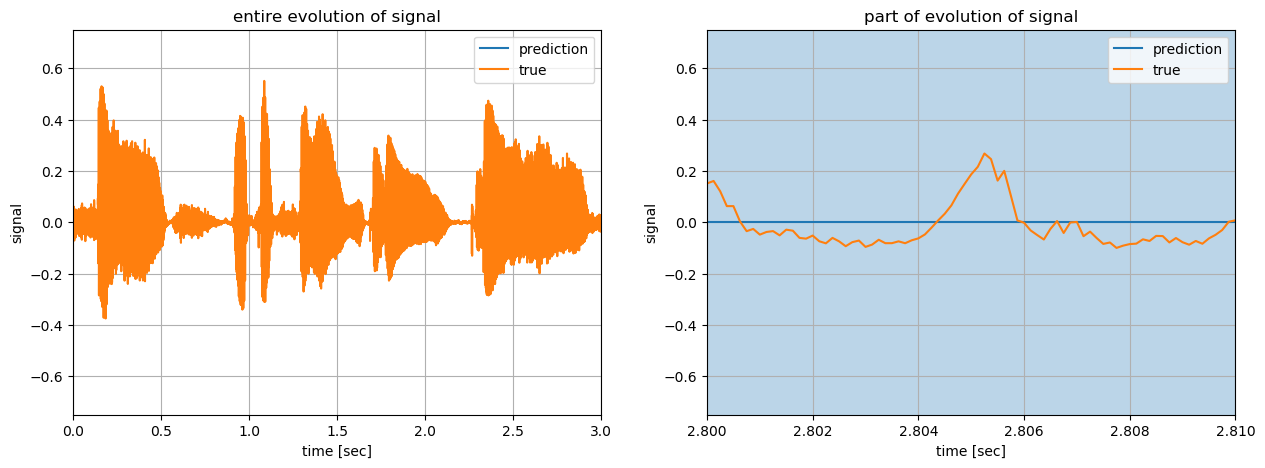

In [18]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t, Œº_x_pred, label="prediction"), ax[2].plot(t, Œº_x_pred, label="prediction")
ax[2].fill_between(t, Œº_x_pred .- sqrt.(var_x_pred), Œº_x_pred .+ sqrt.(var_x_pred), alpha=0.3)

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t, x_time, label="true"), ax[2].plot(t, x_time, label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(2.8, 2.81), ax[2].set_ylim(-0.75,0.75), ax[1].set_ylim(-0.75, 0.75)

audioplayers(x_time, Œº_x_pred, fs=fs_desired)
;

## Visualize parameters

In [19]:
# loop through auto-regressive coefficients
for ki = 1:AR_order
    
    # plot auto-regressive coefficients
    plt.plot(t, [Œº_Œ∏_mem[k][ki] for k=1:length(Œº_Œ∏_mem)])
    
    plt.fill_between(t, [Œº_Œ∏_mem[k][ki] for k=1:length(Œº_Œ∏_mem)] .- sqrt.([1/Œõ_Œ∏_mem[k][ki,ki] for k=1:length(Œº_Œ∏_mem)]), [Œº_Œ∏_mem[k][ki] for k=1:length(Œº_Œ∏_mem)] .+ sqrt.([1/Œõ_Œ∏_mem[k][ki,ki] for k=1:length(Œº_Œ∏_mem)]), alpha=0.3)
    
end

# change visualization
plt.grid(), plt.ylim(-0.75, 0.75), plt.xlim(0, 3), plt.xlabel("time [sec]"), plt.ylabel("auto-regressive coefficients Œ∏"), plt.title("Evolution of auto-regressive coefficients")
;

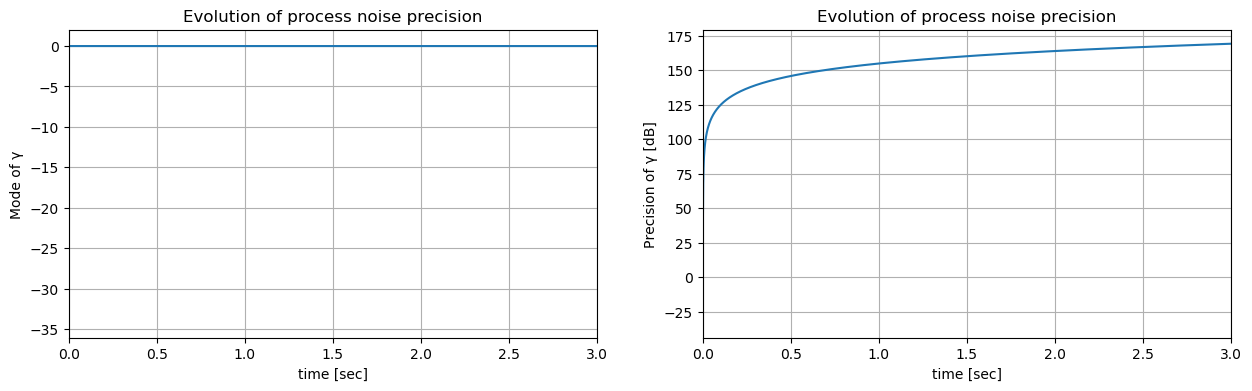

In [20]:
_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[1].plot(t, [(a_Œ≥_mem[k]-1)/b_Œ≥_mem[k] for k = 1:length(a_Œ≥_mem)])
ax[2].plot(t, [10*log10.(b_Œ≥_mem[k]^2/a_Œ≥_mem[k]) for k = 1:length(a_Œ≥_mem)])

# change visualization
ax[1].grid(), ax[1].set_xlim(0, 3), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("Mode of Œ≥"), ax[1].set_title("Evolution of process noise precision")
ax[2].grid(), ax[2].set_xlim(0, 3), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("Precision of Œ≥ [dB]"), ax[2].set_title("Evolution of process noise precision")
;

## Plot final spectral estimate

In [21]:
using Distributions
include("visualization.jl")
;

In [22]:
Œº_Œ∏_cur = Œº_Œ∏_mem[end]
Œõ_Œ∏_cur = Œõ_Œ∏_mem[end]
a_Œ≥_cur = a_Œ≥_mem[end]
b_Œ≥_cur = b_Œ≥_mem[end]

Œ∏, Œ≥ = AR_distributions(Œº_Œ∏_cur, Œõ_Œ∏_cur, a_Œ≥_cur, b_Œ≥_cur)
mean_psd, std_psd = summary_psd(Œ∏, Œ≥)

_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[2].plot(FFTW.fftfreq(length(x_time), fs_desired)/fs_desired*2*pi, 10*log10.((abs.(FFTW.fft(x_time)).^2)./length(x_time)))
plot_psd(ax[1], mean_psd, std_psd)
plot_psd(ax[2], mean_psd, std_psd)

ax[1].grid(), ax[1].set_xlabel("relative frequency Œ∏ [rad]"), ax[1].set_ylabel("power spectral density [dB]"), ax[1].set_title("Posterior PSD"), ax[1].set_xlim(0, pi)
ax[2].grid(), ax[2].set_xlabel("relative frequency Œ∏ [rad]"), ax[2].set_ylabel("power spectral density [dB]"), ax[2].set_title("Posterior PSD"), ax[2].set_xlim(0, pi), ax[2].set_ylim(-100,0)
;